[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/jkanclerz/data-science-workshop-2021/blob/main/90--trains/12--data-exploration-map.ipynb)




In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz -O spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q pyspark findspark

In [111]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder \
    .master("local") \
    .appName("Test it 2") \
    .getOrCreate()
sc = spark.sparkContext

In [112]:
from pyspark.sql import types

In [113]:
types.StructType?

In [114]:
from pyspark.sql import types
from pyspark.sql.types import StructType, LongType, StructField, TimestampType

In [115]:
StructField?

In [116]:
from pyspark.sql import types
from pyspark.sql.types import StructType, LongType, StructField, TimestampType, StringType

# root
#  |-- train_id: long (nullable = true)
#  |-- train_name: string (nullable = true)
#  |-- schedule_date: timestamp (nullable = true)
#  |-- schedule_id: long (nullable = true)
#  |-- arrival_delay: long (nullable = true)
#  |-- arrival_time: timestamp (nullable = true)
#  |-- departure_delay: long (nullable = true)
#  |-- departure_time: timestamp (nullable = true)
#  |-- station_name: string (nullable = true)

schema = StructType([
        StructField('train_id', LongType()),
        StructField('train_name', StringType()),
        StructField('schedule_date', TimestampType()),
        StructField('schedule_id', LongType()),
        StructField('arrival_delay', LongType()),
        StructField('arrival_time', TimestampType()),
        StructField('departure_delay', LongType()),
        StructField('departure_time', TimestampType()),
        StructField('station_name', StringType())
])
    
trains = spark.read.format("csv")\
        .schema(schema)\
        .option("inferSchema", "true")\
        .load("trains_sample.csv")

In [119]:
trains.printSchema()

root
 |-- train_id: long (nullable = true)
 |-- train_name: string (nullable = true)
 |-- schedule_date: timestamp (nullable = true)
 |-- schedule_id: long (nullable = true)
 |-- arrival_delay: long (nullable = true)
 |-- arrival_time: timestamp (nullable = true)
 |-- departure_delay: long (nullable = true)
 |-- departure_time: timestamp (nullable = true)
 |-- station_name: string (nullable = true)



In [120]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)


In [121]:
trains.registerTempTable("trains")

In [122]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


In [123]:
LOCATION_URL = 'https://www.bazakolejowa.pl/index.php?dzial=stacje&id={}&ed=0&okno=polozenie'

In [124]:
urls = [
    LOCATION_URL.format(_id)
    for _id in range(0, 40000)
]

In [125]:
urls = sc.parallelize(urls)

In [126]:
import requests

In [127]:
urls.take(2)

['https://www.bazakolejowa.pl/index.php?dzial=stacje&id=0&ed=0&okno=polozenie',
 'https://www.bazakolejowa.pl/index.php?dzial=stacje&id=1&ed=0&okno=polozenie']

In [128]:
example = 'https://www.bazakolejowa.pl/index.php?dzial=stacje&id=20&ed=0&okno=polozenie'

In [129]:
r = requests.get(example)

In [130]:
example_coords_text = """
    <script>
    mapInit(17.305097579956, 52.947267399096,9);
        x = createStationMarker(17.305097579956, 52.947267399096,20, 'Gołańcz', 'wielkopolskie');
        x.addTo(map); //.openPopup();
            map.addLayer(osmGS)

</script>
"""

In [147]:
import re

def extract_coords(text):

    fn_match = re.search(r"createStationMarker\(.+\)", text)
    try:
        if fn_match:
            text = fn_match[0]
            text = text.replace('createStationMarker(', '',)[:-1]
            parts = text.split(',')
            parts = [part.strip() for part in parts]
            parts = [part.replace("'", "") for part in parts]
            return (float(parts[0]), float(parts[1]), parts[3])
    except ValueError as e:
        return None
    except Error as e:
        return None

assert (17.305097579956, 52.947267399096, 'Gołańcz') == extract_coords(example_coords_text)

In [148]:
urls\
    .map(requests.get)\
    .filter(lambda r: r.status_code == 200)\
    .map(lambda r: r.text)\
    .map(extract_coords)\
    .filter(lambda x: x is not None)\
    .take(10)

[(17.734551429749, 52.849774139808, 'Żnin'),
 (17.4971, 52.843, 'Damasławek'),
 (17.2024, 52.8095, 'Wągrowiec'),
 (17.14403629303, 52.634000538908, 'Sława Wielkopolska'),
 (16.9112, 52.4013, 'Poznań Główny'),
 (18.244, 52.8049, 'Inowrocław'),
 (17.4856, 52.7556, 'Janowiec Wielkopolski'),
 (17.6047, 52.5296, 'Gniezno'),
 (17.946, 52.6582, 'Mogilno'),
 (16.8293, 52.6574, 'Oborniki Wielkopolskie')]

In [149]:
first_100 = urls\
    .map(requests.get)\
    .filter(lambda r: r.status_code == 200)\
    .map(lambda r: r.text)\
    .map(extract_coords)\
    .filter(lambda x: x is not None)\
    .take(1000)

In [150]:
type(first_100)

list

In [151]:
first_100[:10]

[(17.734551429749, 52.849774139808, 'Żnin'),
 (17.4971, 52.843, 'Damasławek'),
 (17.2024, 52.8095, 'Wągrowiec'),
 (17.14403629303, 52.634000538908, 'Sława Wielkopolska'),
 (16.9112, 52.4013, 'Poznań Główny'),
 (18.244, 52.8049, 'Inowrocław'),
 (17.4856, 52.7556, 'Janowiec Wielkopolski'),
 (17.6047, 52.5296, 'Gniezno'),
 (17.946, 52.6582, 'Mogilno'),
 (16.8293, 52.6574, 'Oborniki Wielkopolskie')]

In [ ]:
DF = sqlContext.createDataFrame(first_100, ['lat', 'lng', 'station_name'])

In [ ]:
DF.printSchema()

In [ ]:
DF.registerTempTable('stations')

In [ ]:
sqlContext.sql("""
    Select * from stations LIMIT 5
""").show()

In [ ]:
sqlContext.sql('''
    Select * from trains t
    JOIN stations s
    ON s.station_name = t.station_name
    limit 4
''').show()


### pozostaje narysować mapę najbardziej opóźnionych stacji, połączeń, siatki połączęń itp 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import folium

In [109]:
!wget -nc https://www.eea.europa.eu/data-and-maps/data/eea-reference-grids-2/gis-files/poland-shapefile/at_download/file

File ‘file’ already there; not retrieving.



In [6]:
!unzip file -d poland

Archive:  file
  inflating: poland/pl_100km.png     
  inflating: poland/pl_100km.dbf     
  inflating: poland/pl_100km.prj     
  inflating: poland/pl_100km.shp     
  inflating: poland/pl_100km.shx     
  inflating: poland/pl_10km.png      
  inflating: poland/pl_10km.dbf      
  inflating: poland/pl_10km.prj      
  inflating: poland/pl_10km.shp      
  inflating: poland/pl_10km.shx      
  inflating: poland/pl_1km.png       
  inflating: poland/pl_1km.dbf       
  inflating: poland/pl_1km.prj       
  inflating: poland/pl_1km.shp       
  inflating: poland/pl_1km.shx       


In [152]:
stations_coords = first_100

In [153]:
pl_map = gpd.read_file('./poland/pl_10km.shp')

In [154]:
from shapely.geometry import Point

In [155]:
df = pd.DataFrame(stations_coords, columns=['longitude', 'latitude', 'station'])

In [156]:
df[:10]

,longitude,latitude,station
0,17.734551,52.849774,Żnin
1,17.497100,52.843000,Damasławek
2,17.202400,52.809500,Wągrowiec
3,17.144036,52.634001,Sława Wielkopolska
4,16.911200,52.401300,Poznań Główny
5,18.244000,52.804900,Inowrocław
6,17.485600,52.755600,Janowiec Wielkopolski
7,17.604700,52.529600,Gniezno
8,17.946000,52.658200,Mogilno
9,16.829300,52.657400,Oborniki Wielkopolskie


In [157]:
geometry=[Point(xy) for xy in zip(df['longitude'], df['latitude'])]

In [165]:
geo_df = gpd.GeoDataFrame(df, geometry=geometry, crs=pl_map.crs)

In [166]:
geo_df[:10]

,longitude,latitude,station,geometry
0,17.734551,52.849774,Żnin,POINT (17.734551429749 52.849774139808)
1,17.497100,52.843000,Damasławek,POINT (17.4971 52.843)
2,17.202400,52.809500,Wągrowiec,POINT (17.2024 52.8095)
3,17.144036,52.634001,Sława Wielkopolska,POINT (17.14403629303 52.634000538908)
4,16.911200,52.401300,Poznań Główny,POINT (16.9112 52.4013)
5,18.244000,52.804900,Inowrocław,POINT (18.244 52.8049)
6,17.485600,52.755600,Janowiec Wielkopolski,POINT (17.4856 52.7556)
7,17.604700,52.529600,Gniezno,POINT (17.6047 52.5296)
8,17.946000,52.658200,Mogilno,POINT (17.946 52.6582)
9,16.829300,52.657400,Oborniki Wielkopolskie,POINT (16.8293 52.6574)


<AxesSubplot:>

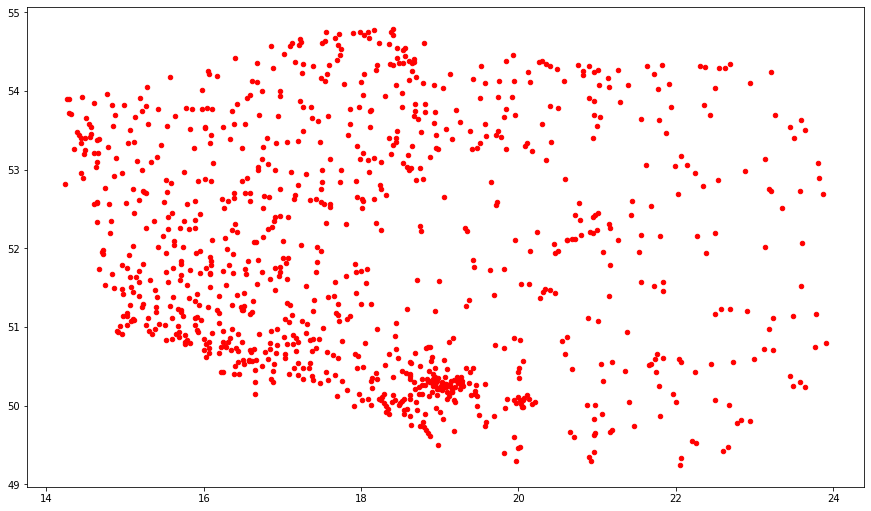

In [176]:
fig,ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
geo_df.plot(ax=ax, color='red', marker="o", markersize=20)


### jak wyglada relacja przykładowego pociagu

In [53]:
sqlContext.sql("""
    Select train_id, t.station_name, lat, lng from trains t
    LEFT JOIN stations s
    ON s.station_name = t.station_name
    WHERE train_id = 2523
    AND schedule_id = 50110944
    ORDER by arrival_time ASC
""").show()

+--------+--------------------+-------+-------+
|train_id|        station_name|    lat|    lng|
+--------+--------------------+-------+-------+
|    2523|       Poznań Główny|16.9112|52.4013|
|    2523|         Poznań Wola|   null|   null|
|    2523|              Kiekrz|   null|   null|
|    2523|          Rokietnica|16.7539|52.5119|
|    2523|          Pamiątkowo|   null|   null|
|    2523|           Baborówko|   null|   null|
|    2523|           Szamotuły|16.5853|52.6034|
|    2523|             Pęckowo|   null|   null|
|    2523|              Wronki|16.3855|52.7051|
|    2523|               Mokrz|   null|   null|
|    2523|               Miały|   null|   null|
|    2523|        Drawski Młyn|16.0943|52.8599|
|    2523|               Krzyż|16.0176|52.8772|
|    2523|             Drawiny|   null|   null|
|    2523|           Podlesiec|   null|   null|
|    2523|Mierzęcin Strzelecki|   null|   null|
|    2523|          Dobiegniew|   null|   null|
|    2523|           Bierzwnik|   null| 

In [177]:
sc.stop()